# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per square mile (by Census Tract) 

### BRONX

In [229]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [230]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [231]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [232]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [233]:
# look at only Bronx
BX_trees_cap = trees_cts.query("county == 'Bronx'")

[Text(0.5, 1.0, 'Bronx')]

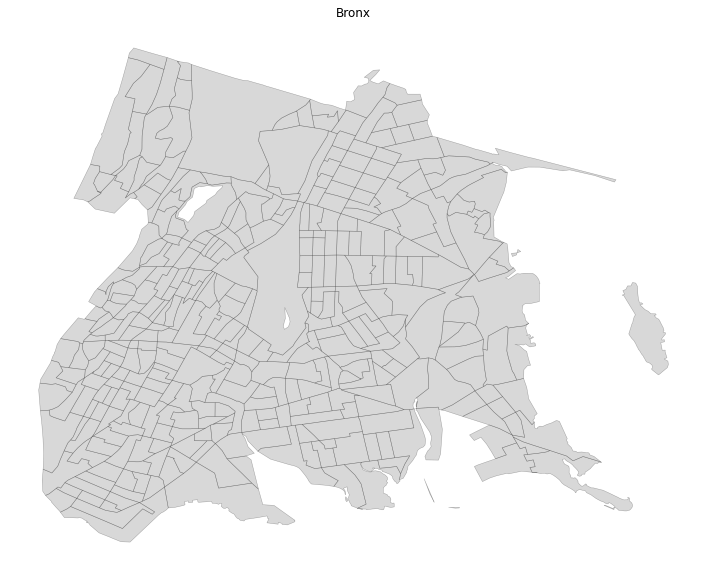

In [234]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Bronx')

In [235]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
BX_trees_cap = BX_trees_cap.dropna(subset = ['trees_per_sqmile'])

In [236]:
# re-check for NaN values
BX_trees_cap['trees_per_sqmile'].isnull().values.any()

False

In [237]:
# drop trees per capita with 0
BX_trees_cap = BX_trees_cap.query("trees_per_sqmile > 0")

In [238]:
# check min value
BX_trees_cap['trees_per_sqmile'].min()

46.7343738673079

In [239]:
# check max value
BX_trees_cap['trees_per_sqmile'].max()

5343.035885407994

In [241]:
w_BX = weights.Queen.from_dataframe(BX_trees_cap)

In [244]:
w_BX = weights.KNN.from_dataframe(BX_trees_cap, k=1)

In [243]:
w_BX = weights.attach_islands(w_BX, w_knn_BX)

There are no disconnected observations (no islands)!


In [245]:
# row standardize weights
w_BX.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per capita*

In [246]:
# on trees per capita
local_moran_BX = esda.moran.Moran_Local(BX_trees_cap['trees_per_sqmile'], w_BX)

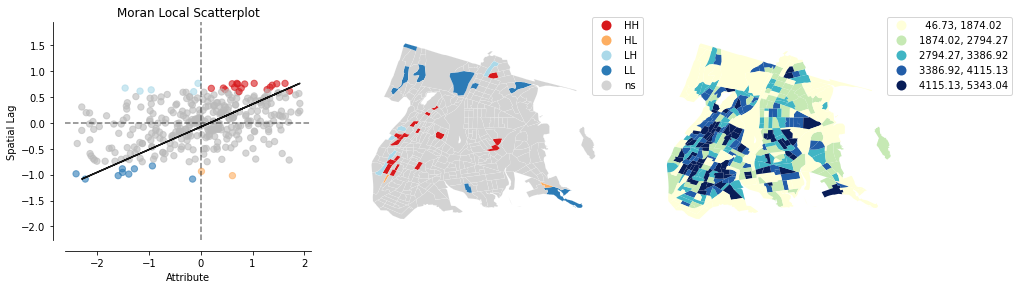

In [247]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BX, BX_trees_cap,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Bronx/Broonx_Trees-per-SquareMile_moran.pdf")

In [248]:
# get clusters and outliers - adding columns to the DF

BX_trees_cap['local_moran_Is'] = local_moran_BX.Is
BX_trees_cap['local_moran_p_value'] = local_moran_BX.p_sim
BX_trees_cap['local_moran_quadrant'] = local_moran_BX.q

In [249]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BX = BX_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

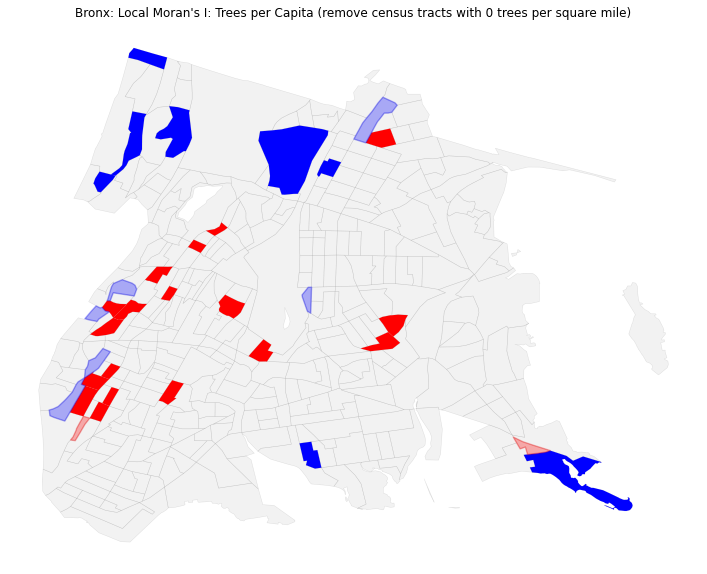

In [228]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BX_trees_cap.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BX.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BX.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BX.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BX.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Bronx: Local Moran's I: Trees per Capita (remove census tracts with 0 trees per square mile)")

plt.savefig("maps/Bronx/Bronx_Trees-per-SquareMile.pdf")

### *investigate the numbers*

In [203]:
# look at smallest values
BX_trees_cap['trees_per_sqmile'].nsmallest(n=10)

1639     46.734374
1117     74.180313
1811    181.825732
536     181.836494
1813    264.404167
1638    286.682290
1830    366.272915
995     366.325566
1730    375.095704
1679    377.055785
Name: trees_per_sqmile, dtype: float64

In [209]:
# look at largest values
BX_trees_cap['trees_per_sqmile'].nlargest(n=10)

7       5343.035885
409     5342.053107
1827    5320.666735
791     5306.345490
747     5243.677224
1740    5131.392437
1024    5097.398925
411     5090.070346
465     5074.531482
1868    5007.041503
Name: trees_per_sqmile, dtype: float64

In [205]:
# lowest 1% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.01))

225.5973605390228


In [177]:
# lowest 5% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.05))

756.5266958437588


In [178]:
# lowest 10% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.10))

1249.3956581242712


In [179]:
# lowest 20% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.20))

1874.0173913374983


In [180]:
# highest 1% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.99))

5273.131309361079


In [181]:
# highest 5% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.95))

4869.9963305099345


In [182]:
# highest 10% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.90))

4597.365441049132


In [183]:
# highest 20% of data
print(BX_trees_cap['trees_per_sqmile'].quantile(q = 0.80))

4115.130936216744


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 200 and more than 5,000  trees per square mile*

In [250]:
# limit the range
BX_trees_cap_limit = BX_trees_cap.query("trees_per_sqmile > 200 & trees_per_sqmile < 5000")

In [252]:
w_BX2 = weights.Queen.from_dataframe(BX_trees_cap_limit)

In [254]:
w_BX2 = weights.KNN.from_dataframe(BX_trees_cap_limit, k=1)

In [255]:
w_BX2 = weights.attach_islands(w_BX2, w_knn_BX2)

There are no disconnected observations (no islands)!


In [256]:
# row standardize weights
w_BX2.transform = 'R'

In [257]:
# on trees per capita
local_moran_BX2 = esda.moran.Moran_Local(BX_trees_cap_limit['trees_per_sqmile'], w_BX2)

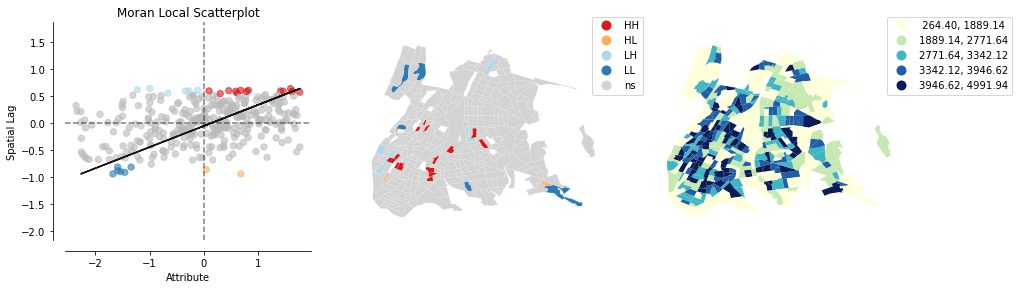

In [258]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BX2, BX_trees_cap_limit,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Bronx/Broonx_Trees-per-SquareMile_limited_moran.pdf")

In [199]:
# get clusters and outliers
BX_trees_cap_limit['local_moran_Is'] = local_moran_BX2.Is
BX_trees_cap_limit['local_moran_p_value'] = local_moran_BX2.p_sim
BX_trees_cap_limit['local_moran_quadrant'] = local_moran_BX2.q

In [200]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BX2 = BX_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

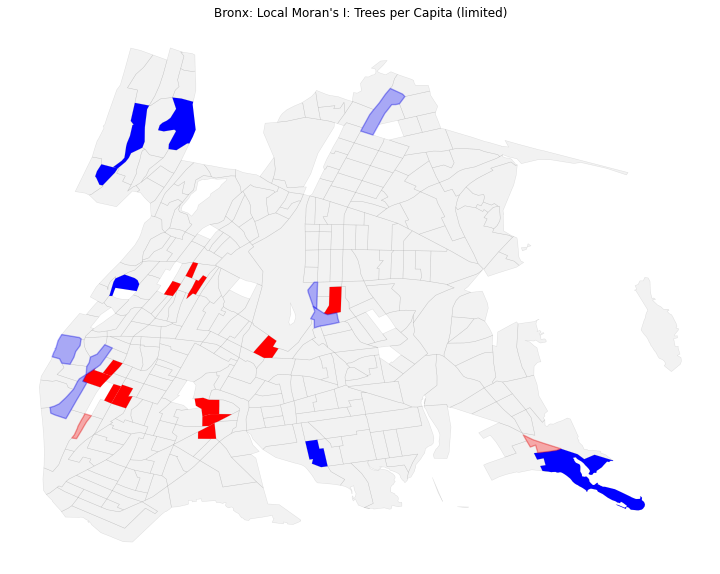

In [226]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BX_trees_cap_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BX2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BX2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BX2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BX2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Bronx: Local Moran's I: Trees per Capita (limited)")

plt.savefig("maps/Bronx/Bronx_Trees-per-SquareMile_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 500 and more than 4,500  trees per square mile*

In [259]:
# limit the range
BX_trees_cap_limit_more = BX_trees_cap.query("trees_per_sqmile > 500 & trees_per_sqmile < 4500")

In [261]:
w_BX3 = weights.Queen.from_dataframe(BX_trees_cap_limit_more)

In [263]:
w_BX3 = weights.KNN.from_dataframe(BX_trees_cap_limit_more, k=1)

In [264]:
w_BX3 = weights.attach_islands(w_BX3, w_knn_BX3)

There are no disconnected observations (no islands)!


In [265]:
# row standardize weights
w_BX3.transform = 'R'

In [266]:
# on trees per capita
local_moran_BX3 = esda.moran.Moran_Local(BX_trees_cap_limit_more['trees_per_sqmile'], w_BX3)

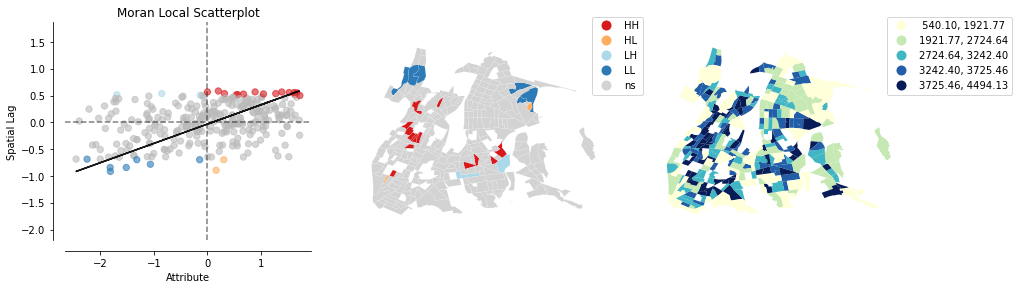

In [267]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BX3, BX_trees_cap_limit_more,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Bronx/Broonx_Trees-per-SquareMile_more-limited_moran.pdf")

In [220]:
# get clusters and outliers
BX_trees_cap_limit_more['local_moran_Is'] = local_moran_BX3.Is
BX_trees_cap_limit_more['local_moran_p_value'] = local_moran_BX3.p_sim
BX_trees_cap_limit_more['local_moran_quadrant'] = local_moran_BX3.q

In [221]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BX3 = BX_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

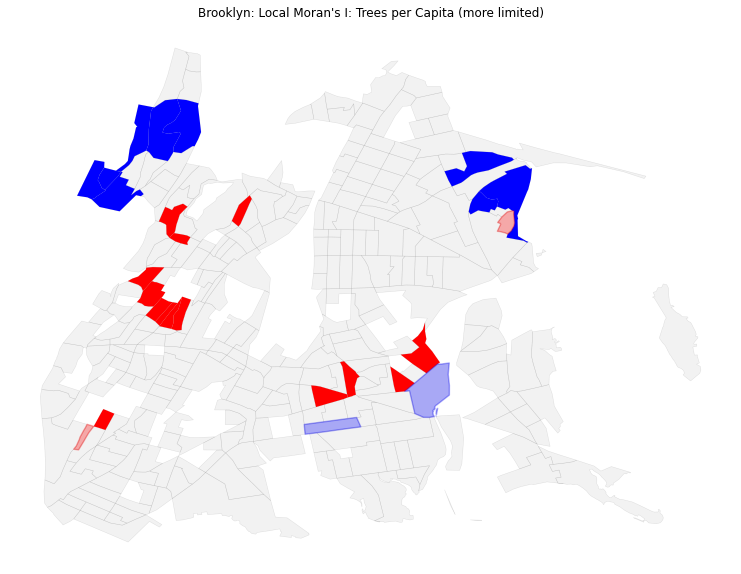

In [227]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BX_trees_cap_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BX_trees_cap_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BX3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BX3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BX3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BX3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Capita (more limited)")

plt.savefig("maps/Bronx/Bronx_Trees-per-SquareMile_more-limited.pdf")